In [1]:
import networkx as nx
import pandas as pd
from nf1 import *
import community
from networkx.algorithms.community import *
%pylab inline
%matplotlib inline
import seaborn as sns
from functools import *
from bokeh.io import output_notebook, show, save,output_file
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.MultiPlot import MultiPlot
import scipy.stats as st
import demon as d
from pquality.PartitionQuality import pquality_summary
from pylab import rcParams
from collections import defaultdict
import json
import ndlib.models.epidemics.SISModel as sis
import ndlib.models.epidemics.SIModel as si
import ndlib.models.epidemics.SIRModel as sir
import ndlib.models.epidemics.ThresholdModel as th
import ndlib.models.ModelConfig as mc
from bokeh.models.annotations import Title
rcParams['figure.figsize'] = 7, 5
from collections import Counter
from itertools import chain
from copy import deepcopy

Populating the interactive namespace from numpy and matplotlib


# Data Collection

In [2]:
df = pd.read_csv('dataset.csv', sep=",")
df.head()

,Source,Target,Weight,Timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [32]:
#classe grafo con alcune membri predefiniti
class Graph(object):
    
    
    def __init__(self, g, name):
        self.g = g
        self.name = name
        self.N = g.order()
        self.E = g.size()
        self.density = nx.density(self.g)
            
    def componentOverlap(self,p):
        inc, dec = p
        self.increasingoverlap = inc
        self.decreasingoverlap = dec
        
    def setDensity(self):
        self.density = nx.density(self.g)

    def getDensity(self):    
        return self.density
    def overlap(self,ov):
        self.overlapping_coefficient = ov
            
    def getOverlap(self):
        return self.kcoms
    def getlcoms(self):    
        return self.lcoms
    def getdcoms(self):    
        return dcoms
    def getlocoms(self):    
        return self.locoms
    def getkcoms(self):    
        return self.locoms
    def getDensity(self):    
        return self.density
    def lcoms(self,lcoms):
        self.lcoms = lcoms  
    def kcoms(self,kcoms):
        self.kcoms = kcoms      
    def dcoms(self,dcoms):
        self.dcoms = dcoms  
    def locoms(self,locoms):
        self.locoms = locoms   
    def avg(self):
         self.avg_deg = float(self.E)/self.N      
    def degree(self):
        self.degrees = sorted([ v for (k , v ) in self.g.degree()], reverse=True)
    def degreeCen(self,deg):
        self.degC = deg
    def betCen(self,deg):
        self.degB = deg
    def closeCen(self,deg):
        self.degClose = deg

In [4]:
#df['Weight'] = (df['Weight']-min(df['Weight']))/(max(df['Weight'])-min(df['Weight']))
df.head()

,Source,Target,Weight,Timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [5]:
#!jupyter nbconvert --to script ARS_AnalyticsTask.ipynb
#!jupyter nbconvert --to html ARS_AnalyticsTask.ipynb

Moreover, the statistics computed on the crawled data must be compared with
the ones of (i) random and (ii) preferential attachment graphs having the same
number of nodes.

In [6]:
nt = nx.DiGraph(name="Bitcoin Over The Counter")
nt = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr  =['Weight'])
g = nt.copy()
ER = nx.erdos_renyi_graph(nt.number_of_nodes(), 0.1)
BA = nx.barabasi_albert_graph(nt.number_of_nodes(), 3, seed=None)
graphs = []
##viene creato un array formato di oggetti Graph
graphs.append(Graph(g,"Bitcoin"))
graphs.append(Graph(ER, "Erdos Renyi"))
graphs.append(Graph(BA, "Barabasi Albert"))

In [7]:
def statistic(graph):
    """
    Vengono calcolate le funzioni base del grafo
    """
    print("Nome rete analizzata: %s" % graph.name)
    print(nx.info(graph.g))
    print("Numero di self-loops",nx.number_of_selfloops(graph.g))
    print("Avg_degree:", graph.avg() )
    print("La densita è %s" % graphs[0].getDensity())
    print("Media gradi:", np.mean(graph.degrees))
    print("Moda gradi:",st.mode(graph.degrees))
    print("Mediana gradi:",np.median(graph.degrees))

In [11]:
#vengono inseriti in una lista la lista dei vicini in comune per ogni edge presente nel grafo
overlapping_coefficents = []
for x, y in graphs[0].g.edges():
    overlapping_coefficents.append((x, y, len(list(nx.common_neighbors(graphs[0].g, x, y)))))
    overlapping_coefficents = sorted(overlapping_coefficents, key=lambda tup: tup[2])
graphs[0].overlap(overlapping_coefficents) 

In [92]:
#Viene fatto il plot dei gradi di ogni nodo del grafo
def degree_centrality(graph,str):
    def n_node_outdegree(g,out):
        return reduce(lambda c , n : c + 1 if g.out_degree( out ) < 1 else c , g.nodes()
                , 0)
    def n_node_outdegree(g,inner):
        return reduce(lambda c , n : c + 1 if g.in_degree( inner ) < 1 else c , g.nodes()
                , 0)
    print("Degree Centrality:")
    fun1 =  list(map(lambda x: graph.degree(x), graph.nodes()))
  #  fun2 =  list(map(lambda x: graph.out_degree(x), graph.nodes()))
  #  fun3 =  list(map(lambda x: graph.in_degree(x), graph.nodes()))
    plot_degree_distribution(fun1, str )
  #  plot_degree_distribution(fun2, "Out Degree Distribution" )
  #  plot_degree_distribution(fun3, "In Degree Distribution")

In [58]:
#valuto la migliore centralità passata nell'argomento **kwargs
def nbest_centrality(graph, metric, n=100,
    attribute="centrality", **kwargs):
    centrality = metric(graph, **kwargs)
  #  nx.set_node_attributes(graph, centrality,attribute)
    degrees = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    #utilizzato per valutare i primi n nodi più centrali
    #for idx, item in enumerate(degrees[0:n]):
     #   item = (idx+1,) + item
     #   print("%i. %s: %0.3f" % item)
    return degrees

In [53]:
#plotting della rete
def plotting(graph):
    graph = graph.to_undirected(True)
    nx.draw(graph)
    pos=nx.spring_layout(graph)
    # Find the center Node
    dmin=1
    ncenter=0
    for n in pos:
        x,y=pos[n]
        d=(x-0.5)**2+(y-0.5)**2
        if d<dmin:
            ncenter=n
            dmin=d
    p=nx.single_source_shortest_path_length(graph,ncenter)
    plt.figure(figsize=(8,8))
    nx.draw_networkx_edges(graph,pos,nodelist=[ncenter],alpha=0.4)
    nx.draw_networkx_nodes(graph,pos,nodelist=list(p.keys()),node_size=90,node_color=list(p.values()),cmap=plt.cm.Reds_r)
    plt.show()

In [54]:
def distributions_plotting(graphs): 
    plt.loglog(graphs[0].degrees, label=graphs[0].name, color='b',marker='o')
    plt.loglog(graphs[1].degrees, label=graphs[1].name, color='r',marker='o')
    plt.loglog(graphs[2].degrees, label=graphs[2].name, color='g',marker='o')
    plt.legend()
    plt.ylabel('DC')
    plt.xlabel('nodes')
    plt.savefig('degree_distribution.png', format='png')
    plt.close()

In [55]:
def plot_degree_distribution (deg, str) :
    degs = {}
    for n in deg :
        if n not in degs :
            degs [ n ] = 0
        degs [ n ] += 1
    items = sorted(degs.items())
    fig = figure()
    ax = fig.add_subplot(111)
    ax.plot( [ v for (k ,v ) in items ],[ k for (k , v ) in items ],marker='o',linestyle="None")
    ax.set_xscale('log')
    ax.set_yscale( 'log')
    plt.title( str )
    plt.ylabel("#nodes")
    plt.xlabel("degree")
    fig.savefig ( str + "png " )

# Network Analysis

In [64]:
for obj in graphs:
    obj.degree()
    statistic(obj)

Nome rete analizzata: Bitcoin
Name: 
Type: Graph
Number of nodes: 5875
Number of edges: 21489
Average degree:   7.3154
Numero di self-loops 0
Avg_degree: None
La densita è 0.001243020588612932
Media gradi: 7.31540425532
Moda gradi: ModeResult(mode=array([1]), count=array([2254]))
Mediana gradi: 2.0
Nome rete analizzata: Erdos Renyi
Name: 
Type: Graph
Number of nodes: 5881
Number of edges: 1726507
Average degree: 587.1474
Numero di self-loops 0
Avg_degree: None
La densita è 0.001243020588612932
Media gradi: 587.147423907
Moda gradi: ModeResult(mode=array([588]), count=array([116]))
Mediana gradi: 587.0
Nome rete analizzata: Barabasi Albert
Name: 
Type: Graph
Number of nodes: 5881
Number of edges: 17634
Average degree:   5.9969
Numero di self-loops 0
Avg_degree: None
La densita è 0.001243020588612932
Media gradi: 5.99693929604
Moda gradi: ModeResult(mode=array([3]), count=array([2310]))
Mediana gradi: 4.0


In [67]:
for obj in graphs:
    print("Transivity:" ,nx.transitivity(obj.g.to_undirected(True)))
    print("Average clustering:" ,nx.average_clustering(obj.g.to_undirected(True)))

Transivity: 0.0592384412258376
Average clustering: 0.17768577523831092


Degree Centrality:
Degree Centrality:
Degree Centrality:


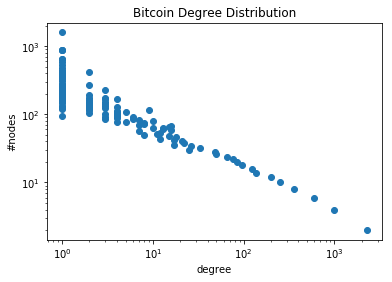

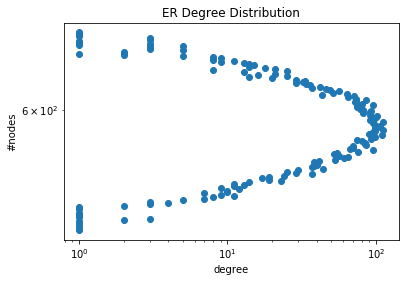

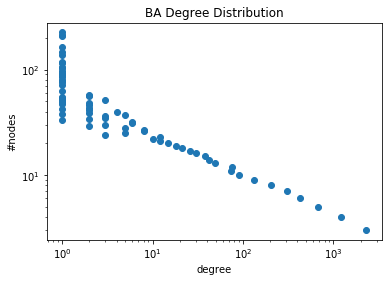

In [115]:
degree_centrality(graphs[0].g.to_directed(), "Bitcoin Degree Distribution")
degree_centrality(graphs[1].g, "ER Degree Distribution")
degree_centrality(graphs[2].g, "BA Degree Distribution")

In [116]:
#plotting(g)

In [54]:
distributions_plotting(graphs)

In [70]:
for obj in graphs:
    d = {'Nodo ' + obj.name: [ item[0]  for idx, item in enumerate(obj.degC)] ,
         'Grado': [  item[1] for idx, item in enumerate(obj.degC)],
         "Nodi": obj.degrees}
    df = pd.DataFrame(data=d)
    obj.df = df.set_index('Nodo ' + obj.name)
    obj.df

Text(0.5,1,'Top 100 Degree')

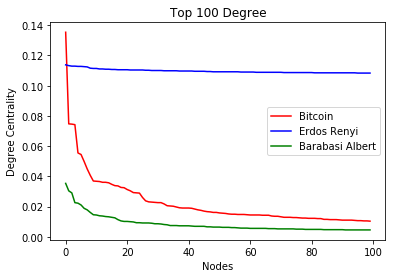

In [59]:
for obj in graphs:
    obj.degreeCen(nbest_centrality(obj.g, nx.degree_centrality))
fig = figure()
ax = fig.add_subplot(111)
ax.plot([  item[1] for idx, item in enumerate(graphs[0].degC[0:100])],'r-') # bitcoin
ax.plot([  item[1] for idx, item in enumerate(graphs[1].degC[0:100])],'b-') # Er
ax.plot([  item[1] for idx, item in enumerate(graphs[2].degC[0:100])],'g-') # Ba
plt.xlabel("Nodes")
plt.ylabel("Degree Centrality")
plt.legend([graphs[0].name,graphs[1].name,graphs[2].name])
plt.title("Top 100 Degree")

In [16]:
graphs[0].df.head()

,Grado Closeness,Nodi
Nodo Bitcoin,,
35.0,0.135204,795
1810.0,0.074660,439
2642.0,0.074490,438
2125.0,0.074150,436
2028.0,0.055442,326


In [17]:
graphs[1].df.head()

,Grado Closeness,Nodi
Nodo Erdos Renyi,,
5730,0.113265,666
3625,0.113095,665
5459,0.112925,664
1288,0.112755,663
1055,0.112415,661


In [18]:
graphs[2].df.head()

,Grado Closeness,Nodi
Nodo Barabasi Albert,,
3,0.038265,225
1,0.035884,211
2,0.035714,210
13,0.027891,164
18,0.024830,146


Note that this computation is extremely expensive and could take a long time
on your computer!

Text(0.5,1,'Top 100 Betweenness Degree')

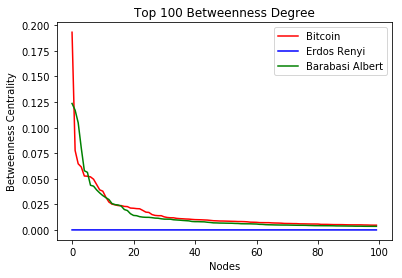

In [27]:
for obj in graphs:
    obj.betCen(nbest_centrality(obj.g, nx.betweenness_centrality, normalized=True))
fig = figure()
ax = fig.add_subplot(111)
ax.plot([  item[1] for idx, item in enumerate(graphs[0].degB[0:100])],'r-') # bitcoin
ax.plot([  item[1] for idx, item in enumerate(graphs[1].degB[0:100])],'b-') # Er
ax.plot([  item[1] for idx, item in enumerate(graphs[2].degB[0:100])],'g-') # Ba
plt.xlabel("Nodes")
plt.ylabel("Betweenness Centrality")
plt.legend([graphs[0].name,graphs[1].name,graphs[2].name])
plt.title("Top 100 Betweenness Degree")

In [28]:
for obj in graphs:
    d = {'Nodo ' + obj.name: [ item[0]  for idx, item in enumerate(obj.degB)] ,
         'Grado Betweenness': [  item[1] for idx, item in enumerate(obj.degB)]}
    df = pd.DataFrame(data=d)
    obj.dfB = df.set_index('Nodo ' + obj.name)

In [29]:
graphs[0].dfB.head()

,Grado Betweenness
Nodo Bitcoin,
35.0,0.193143
2125.0,0.077739
2642.0,0.064724
1810.0,0.061622
1.0,0.052810


In [30]:
graphs[1].dfB.head()

,Grado Betweenness
Nodo Erdos Renyi,
5730,0.000196
4149,0.000195
5459,0.000195
3625,0.000195
1288,0.000194


In [31]:
graphs[2].dfB.head()

,Grado Betweenness
Nodo Barabasi Albert,
3,0.123629
1,0.117080
2,0.104766
13,0.080143
7,0.057952


Text(0.5,1,'Top 100 Closeness Degree')

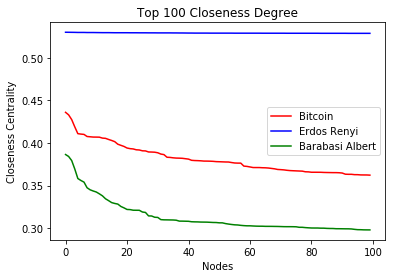

In [32]:
for obj in graphs:
    obj.closeCen(nbest_centrality(obj.g, nx.closeness_centrality))
fig = figure()
ax = fig.add_subplot(111)
ax.plot([  item[1] for idx, item in enumerate(graphs[0].degClose[0:100])],'r-') # bitcoin
ax.plot([  item[1] for idx, item in enumerate(graphs[1].degClose[0:100])],'b-') # Er
ax.plot([  item[1] for idx, item in enumerate(graphs[2].degClose[0:100])],'g-') # Ba
plt.xlabel("Nodes")
plt.ylabel("Closeness Centrality")
plt.legend([graphs[0].name,graphs[1].name,graphs[2].name])
plt.title("Top 100 Closeness Degree")

In [34]:
for obj in graphs:
    d = {'Nodo ' + obj.name: [ item[0]  for idx, item in enumerate(obj.degClose)] ,
         'Grado Closeness': [  item[1] for idx, item in enumerate(obj.degClose)]}
    df = pd.DataFrame(data=d)
    obj.dfC = df.set_index('Nodo ' + obj.name)

In [52]:
nx.transitivity(graphs[2].g)

0.004506750154545636

In [36]:
graphs[1].dfC.head()

,Grado Closeness
Nodo Erdos Renyi,
5730,0.530016
3625,0.529968
5459,0.529921
1288,0.529873
1055,0.529777


In [37]:
graphs[2].dfC.head()

,Grado Closeness
Nodo Barabasi Albert,
3,0.386486
1,0.384188
2,0.379379
13,0.369509
7,0.358318


In [ ]:
largest_cc = max(nx.connected_components(g), key=len)
print("Il componente piu largo della rete è largo :", len(largest_cc))

# Analytical Tasks

## Community

Vengono rimossi i nodi superflui se presenti.

In [45]:
((graphs[0].g.remove_node(6000)) if graphs[0].g.has_node(6000) else 0)
((graphs[0].g.remove_node(3911)) if graphs[0].g.has_node(3911) else 0)
((graphs[0].g.remove_node(3762)) if graphs[0].g.has_node(3762) else 0)
((graphs[0].g.remove_node(6002)) if graphs[0].g.has_node(6002) else 0)
((graphs[0].g.remove_node(3912)) if graphs[0].g.has_node(3912) else 0)
((graphs[0].g.remove_node(3763)) if graphs[0].g.has_node(3763) else 0)

In [100]:
#funzione per la stampa delle misure delle comunità con pquality
def printSummary(g,coms):
    res = pquality_summary(g, coms)
    for _, v in res.items():
        print(v)

## Louvain_Method

In [101]:
def louvain(g):
    part = community.best_partition(g)
    values = [part.get(node) for node in g.nodes()]
    nx.draw_spring(g, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
    print("%i partitions" % len(Counter(values).values()))
    result_dict = defaultdict(list)
    for e,v in part.items():
        result_dict[v].append(e)
    locoms = result_dict.values()
    return locoms, part, values
def hist(values):
    numbins = len(Counter(values).values())
    plt.hist(values, bins=numbins,color="#0f6dbc")
    plt.title("Size of BitCoin Communities with Louvain")
    plt.xlabel("Community")
    plt.ylabel("Nodes")
def bubblechart(part):               
    parts = defaultdict(int)
    for parta in part.values():
        parts[parta] += 1
        bubbles = nx.Graph()
    for parta in parts.items():
        bubbles.add_node(parta[0], size=parta[1])
    pos = nx.random_layout(bubbles)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    nx.draw_networkx_nodes(bubbles, pos,alpha=0.6, node_size=list(map(lambda x: x*6, parts.values())),node_color=[random.random() for x in parts.values()],cmap=plt.cm.RdYlBu)
    plt.show()
    printSummary(g,locoms)

16 partitions


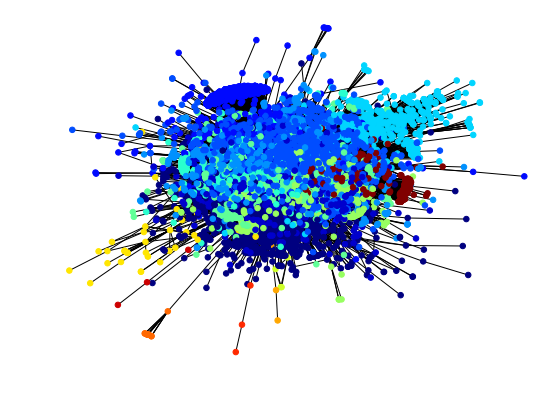

In [102]:
locoms, part,values = louvain(graphs[0].g)
graphs[0].locoms(locoms)

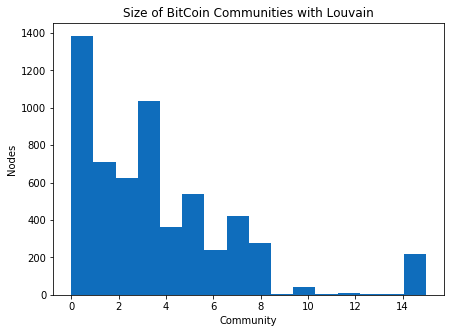

In [103]:
hist(values)

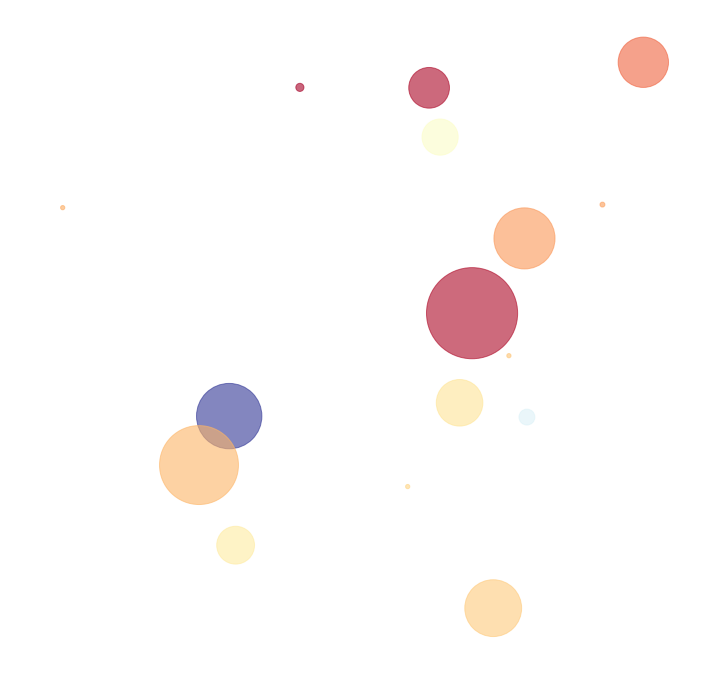

                       min          max         avg          std
Index                                                           
Internal Density  0.000941     0.208333    0.049471     0.074975
Edges inside      2.000000  4048.000000  869.125000  1170.107040
Average Degree    1.333333     6.265896    3.298578     1.667805
FOMD              0.998555     1.000000    0.999910     0.000350
TPR               0.000000     1.000000    0.287040     0.255786
Expansion         0.090909     4.778090    1.810929     1.450129
Cut Ratio         0.000016     0.000925    0.000340     0.000276
Conductance       0.047619     0.564593    0.304440     0.135855
Normalized Cut    0.047642     0.581005    0.327553     0.150009
Maximum-ODF       1.000000   361.000000  124.937500   120.366871
Average-ODF       0.090909     4.778090    1.810929     1.450129
Flake-ODF         0.000000     0.214286    0.073831     0.069025
                            value
Index                            
Modularity (no overlap

In [104]:
bubblechart(part)

## Girvan_Newman

In [105]:
def girvan(G):
    c = nx.connected_component_subgraphs(G)
    l = len(list(c))
    print("The number of connected component are {}".format(l))
    while (l < 3): 
        G.remove_edge(*edge_to_remove(G))    # sa qual'è l'edge da rimuovere
        c = nx.connected_component_subgraphs(G)
        l = len(list(c))
        print("The number of connected component are {}".format(l))
    return c

In [106]:
def edge_to_remove(G):
    dict1 = nx.edge_betweenness_centrality(G)
    list_of_tuples = sorted(dict1.items(), reverse = True)
   # list_of_tuples.sort(key = lambda x: x[1], reverse =  true)
    return list_of_tuples[0][0]

In [ ]:
c = girvan(g)
printSummary(g,c)

## K-Clique

In [23]:
def k_clique(g,rel = range(3,7)):
    k_cricche = {}
    for i in rel:
        k_cricche[i] = list(k_clique_communities(g.to_undirected(True), i))
        print("Numero componenti %s" % (len(k_cricche[i])))
        printSummary(g,k_cricche[i])
    return k_cricche

In [24]:
k_cricche = k_clique(graphs[0].g)
graphs[0].kcoms(k_cricche)

Grandezza componenti 75
                       min           max         avg          std
Index                                                            
Internal Density  0.001336      0.250000    0.236192     0.035383
Edges inside      3.000000  16425.000000  222.626667  1883.488351
Average Degree    2.000000     13.245968    2.298581     1.314189
FOMD              0.997581      1.000000    0.999968     0.000277
TPR               1.000000      1.000000    1.000000     0.000000
Expansion         0.500000    264.666667   35.793928    51.841133
Cut Ratio         0.000085      0.045073    0.006099     0.008827
Conductance       0.121540      0.992500    0.816615     0.186090
Normalized Cut    0.166713      1.010642    0.823519     0.175733
Maximum-ODF       1.000000    793.000000  114.746667   170.023692
Average-ODF       0.500000    264.666667   35.793928    51.841133
Flake-ODF         0.000000      1.000000    0.592768     0.270602
                            value
Index             

## Label Propagation

In [25]:
lp = list(label_propagation_communities(g))
lpcoms = [tuple(x) for x in lp]
print("Numero community: %s " % len(lpcoms))
printSummary(g,lpcoms)
graphs[0].lcoms(lpcoms)

Numero community: 93 
                       min           max         avg          std
Index                                                            
Internal Density  0.000332      0.250000    0.194272     0.065266
Edges inside      1.000000  20164.000000  224.892473  2079.384672
Average Degree    1.000000     18.500000    1.647299     1.984619
FOMD              0.999637      1.000000    0.999996     0.000037
TPR               0.000000      1.000000    0.117457     0.294325
Expansion         0.090909      5.807692    0.890830     0.630282
Cut Ratio         0.000016      0.000997    0.000155     0.000108
Conductance       0.013744      0.500000    0.372359     0.101711
Normalized Cut    0.047642      0.500093    0.374388     0.096443
Maximum-ODF       1.000000     42.000000    2.440860     4.842603
Average-ODF       0.090909      5.807692    0.890830     0.630282
Flake-ODF         0.000000      0.500000    0.021608     0.081267
                            value
Index               

## Demon

In [27]:
def demon(g,epsilon = np.arange(1,7)):
    coms = []
    fig, ax = plt.subplots()
    for t in [x/10 for x in epsilon]:
        D = d.Demon(graph=g, epsilon=t)
        dcoms = D.execute()
        printSummary(g,dcoms)
        print("Grandezza componenti %s" % (len(dcoms)))
        coms.append((len(dcoms)))
    pm = plt.bar(epsilon, coms)
    ax.set_xticks(epsilon)
    ax.set_xticklabels([x/10 for x in epsilon])
    ax.set_ylim([0, 120])
    ax.set_ylabel('Community')
    ax.set_xlabel('Epsilon')

Exec: 100%|████████████████████████


Time:  'execute' 48.04 sec
------------------------------------
                       min           max          avg          std
Index                                                             
Internal Density  0.001305      0.208333     0.108570     0.084685
Edges inside      5.000000  16531.000000  5516.333333  7788.546177
Average Degree    2.500000     13.135479     6.295160     4.846518
FOMD              0.997616      1.000000     0.999205     0.001124
TPR               1.000000      1.000000     1.000000     0.000000
Expansion         0.500000      5.000000     2.427162     1.893000
Cut Ratio         0.000085      0.000852     0.000489     0.000315
Conductance       0.119427      0.606061     0.297385     0.219117
Normalized Cut    0.166713      0.606991     0.401507     0.180934
Maximum-ODF       1.000000    400.000000   138.000000   185.326738
Average-ODF       0.500000      5.000000     2.427162     1.893000
Flake-ODF         0.000000      0.625000     0.210055     0.29341

Exec: 100%|████████████████████████


Time:  'execute' 39.65 sec
------------------------------------
                       min           max          avg          std
Index                                                             
Internal Density  0.001722      0.208333     0.048530     0.076009
Edges inside      5.000000  15138.000000  8158.000000  5661.896250
Average Degree    2.500000     17.127596    12.227228     5.994898
FOMD              0.995697      1.000000     0.997663     0.001571
TPR               1.000000      1.000000     1.000000     0.000000
Expansion         0.500000      8.702275     5.003361     2.806818
Cut Ratio         0.000085      0.001789     0.001057     0.000566
Conductance       0.158111      0.606061     0.294375     0.145629
Normalized Cut    0.166713      0.606991     0.492422     0.142079
Maximum-ODF       1.000000    630.000000   394.857143   255.147816
Average-ODF       0.500000      8.702275     5.003361     2.806818
Flake-ODF         0.000000      0.625000     0.117002     0.20887

Exec: 100%|████████████████████████


Time:  'execute' 48.43 sec
------------------------------------
                       min           max          avg          std
Index                                                             
Internal Density  0.002531      0.250000     0.099887     0.093513
Edges inside      5.000000  12903.000000  3310.346154  4842.984894
Average Degree    2.500000     18.332991     9.256319     6.646790
FOMD              0.990291      1.000000     0.997961     0.002810
TPR               1.000000      1.000000     1.000000     0.000000
Expansion         0.500000    109.000000    27.403660    27.463335
Cut Ratio         0.000085      0.018566     0.004788     0.004628
Conductance       0.166667      0.977578     0.637169     0.272783
Normalized Cut    0.166713      0.987624     0.743505     0.190552
Maximum-ODF       1.000000    787.000000   386.115385   270.371586
Average-ODF       0.500000    109.000000    27.403660    27.463335
Flake-ODF         0.000000      0.800000     0.289011     0.23468

Exec: 100%|████████████████████████


Time:  'execute' 42.00 sec
------------------------------------
                       min           max          avg          std
Index                                                             
Internal Density  0.002202      0.250000     0.103575     0.088778
Edges inside      5.000000  13341.000000  2617.000000  4280.497266
Average Degree    2.500000     20.640000     8.638224     6.418690
FOMD              0.987988      1.000000     0.997975     0.003193
TPR               1.000000      1.000000     1.000000     0.000000
Expansion         0.500000    109.000000    30.274643    27.965887
Cut Ratio         0.000085      0.018566     0.005268     0.004719
Conductance       0.166667      0.977578     0.669342     0.261300
Normalized Cut    0.166713      0.987624     0.763763     0.196075
Maximum-ODF       1.000000    780.000000   375.636364   262.726245
Average-ODF       0.500000    109.000000    30.274643    27.965887
Flake-ODF         0.000000      0.800000     0.299011     0.20588

Exec: 100%|████████████████████████


Time:  'execute' 38.56 sec
------------------------------------
                       min           max          avg          std
Index                                                             
Internal Density  0.002051      0.250000     0.094839     0.082827
Edges inside      5.000000  14200.000000  1779.425532  3642.274019
Average Degree    2.500000     19.842857     7.501986     5.758148
FOMD              0.875000      1.000000     0.995080     0.018768
TPR               1.000000      1.000000     1.000000     0.000000
Expansion         0.500000    111.333333    33.402207    27.324790
Cut Ratio         0.000085      0.018979     0.005774     0.004614
Conductance       0.166667      0.977578     0.734107     0.228699
Normalized Cut    0.166713      0.993729     0.805920     0.164526
Maximum-ODF       1.000000    788.000000   381.872340   252.326167
Average-ODF       0.500000    111.333333    33.402207    27.324790
Flake-ODF         0.000000      0.800000     0.350508     0.19714

Exec: 100%|████████████████████████


Time:  'execute' 42.90 sec
------------------------------------
                       min           max         avg          std
Index                                                            
Internal Density  0.002277      0.250000    0.083191     0.069359
Edges inside      5.000000  13667.000000  784.567568  1940.443609
Average Degree    2.500000     22.254072    7.489407     5.176037
FOMD              0.866667      1.000000    0.992698     0.016801
TPR               1.000000      1.000000    1.000000     0.000000
Expansion         0.500000    152.769231   41.236310    26.900059
Cut Ratio         0.000085      0.026061    0.007099     0.004569
Conductance       0.166667      0.977578    0.799714     0.162092
Normalized Cut    0.166713      1.012070    0.859545     0.129983
Maximum-ODF       1.000000    791.000000  389.243243   257.008263
Average-ODF       0.500000    152.769231   41.236310    26.900059
Flake-ODF         0.000000      1.000000    0.547294     0.239974
            

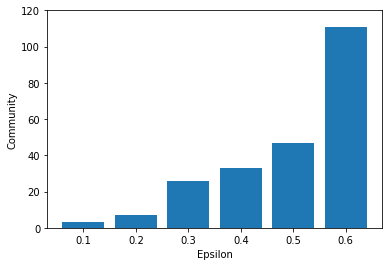

In [28]:
dcoms = demon(graphs[0].g)
graphs[0].dcoms(dcoms)

##  NF1

In [34]:
# Computing the NF1 scores and statistics
#nf = NF1(graphs[0].getkcoms(), graphs[0].getdcoms())
nf = NF1(lpcoms, kcoms) 
results = nf.summary()
print(results['scores'])
print(results['details'])

NameError: name 'lpcoms' is not defined

## Strong Ties

In [107]:
def generate_triangles(nodes):
    """Generate triangles. Weed out duplicates."""
    visited_ids = set() # remember the nodes that we have tested already
    a = []
    for k, v in nodes.items(): #k --> v[node_b_id,...]
        for node_b_id in v:
            if node_b_id in visited_ids:
                continue # we should have already found (no come back)
            for node_c_id in nodes[node_b_id]:    #take all the neighbours od node_b
                if node_c_id in visited_ids:
                    continue # we should have already found c->a->b->c
                if k in nodes[node_c_id]:  #if k is in neighbours of node_c there is a triangle
                    a.append([k, node_b_id, node_c_id])  #nodes 6 2 10   yield in python instead of
        visited_ids.add(k) # don't search a - we already have all those cycles
    return a
nodesN = {}
for i in nx.nodes(g):
    nodesN[i] = [ n for n in g.neighbors(i) ]    #selezioni i nodi con più di due neighbours
#nodesN = dict([(k, v) for k, v in nodesN.items() if len(v) > 1])
a = generate_triangles(nodesN)
print("Numero triangoli %s" % len(a))
st = nx.triangles(graphs[0].g)
print("Numero nodi con triangoli: %s" % len([k for k, v in st.items() if v > 0]))
#print("Media triangoli per nodo: %s" % [sum(st.values()) / len(st.keys())])

Numero triangoli 66986
Numero nodi con triangoli: 2614


In [20]:
def components_stats(g,n):
    print('computing number of components...')
    number_of_components = []
    for x,y, _ in n:
        number_of_components.append(nx.number_connected_components(g))
        e = (x,y)
        g.remove_edge(*(e))
    return number_of_components

def tie_strength(g):
    print('removing nodes in increasing order by common_neighbors')
    g_temp = deepcopy(g)
    number_of_components_increasing = components_stats(g_temp.g,g_temp.overlapping_coefficient)
    
    print('removing nodes in decreasing order by common_neighbors')
    g_temp = deepcopy(g)
    number_of_components_decreasing = components_stats(g_temp.g,list(reversed(g_temp.overlapping_coefficient)))
    plt.ylabel('Numero di componenti')
    plt.xlabel('Numero di link eliminati')
    plt.plot(number_of_components_increasing, label="Ordine crescente")
    plt.plot(number_of_components_decreasing, label="Ordine decrescente")
    plt.legend()
    plt.show()
    return (number_of_components_increasing,number_of_components_decreasing)

removing nodes in increasing order by common_neighbors
computing number of components...
removing nodes in decreasing order by common_neighbors
computing number of components...


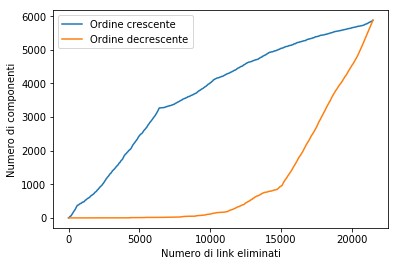

In [21]:
#time required
graphs[0].componentOverlap(tie_strength(graphs[0]))

## Diffusion model to simulate
Specify the parameters 

In [ ]:
def simulateSI(graph,par):
    # Model Configuration
    g = graph.g
    vm = MultiPlot()
    for i in par:
        si_model = si.SIModel(g)
        config = mc.Configuration()
        config.add_model_parameter('beta', i)
        config.add_model_parameter("percentage_infected", 0.05)
        si_model.set_initial_status(config)
        iterations = si_model.iteration_bunch(200)
        trends = si_model.build_trends(iterations)
        viz = DiffusionTrend(si_model, trends)
        p4 = viz.plot(width=400, height=400)
        t = Title()
        t.text = graph.name
        p4.title = t
        vm.add_plot(p4)
    # Simulation
    print(json.dumps(si_model.parameters, indent=2))
    m = vm.plot()
 #   show(m)
    output_file(graph.name+'SI.html')
    save(m)
def simulateSIR(graph,par): 
    vm = MultiPlot()
    g = graph.g
    for i in par:
        sir_model = sir.SIRModel(g)
        config = mc.Configuration()
        config.add_model_parameter('beta', i[0])
        config.add_model_parameter('gamma', i[1])
        config.add_model_parameter("percentage_infected", i[2])
        sir_model.set_initial_status(config)
        iterations = sir_model.iteration_bunch(200)
        trends = sir_model.build_trends(iterations)
        viz = DiffusionTrend(sir_model, trends)
        p5 = viz.plot(width=400, height=400)
        t = Title()
        t.text = graph.name
        p5.title = t
        vm.add_plot(p5)
    print(json.dumps(sir_model.parameters, indent=2))
    m = vm.plot()
    #show(m)
    output_file(graph.name+'SIR.html')
    save(m)
def simulateSIS(graph,par): 
    vm = MultiPlot()
    g = graph.g
    for i in par:
        sis_model = sis.SISModel(g)
        config = mc.Configuration()
        config.add_model_parameter('beta', i[0])
        config.add_model_parameter('lambda', i[1] )
        config.add_model_parameter("percentage_infected",i[2])
        sis_model.set_initial_status(config)
        iterations = sis_model.iteration_bunch(200)
        trends = sis_model.build_trends(iterations)
        viz = DiffusionTrend(sis_model, trends)
        p3 = viz.plot(width=400, height=400)
        t = Title()
        t.text = graph.name
        p3.title = t
        vm.add_plot(p3)
    print(json.dumps(sis_model.parameters, indent=2))
    m = vm.plot()
  #  show(m)
    output_file(graph.name+'SIS.html')
    save(m)
def simulateThreshold(graph): 
    vm = MultiPlot()
    g = graph.g
    # Threshold
    th_model = th.ThresholdModel(g)
    config = mc.Configuration()
    # Set individual node threshold
    threshold = 0.40
    for n in g.nodes():
            config.add_node_configuration("threshold", n, threshold)
    config.add_model_parameter("percentage_infected", 0.30)
    th_model.set_initial_status(config)
    iterations = th_model.iteration_bunch(60)
    trends = th_model.build_trends(iterations)
    viz = DiffusionTrend(th_model, trends)
    p6 = viz.plot(width=400, height=400)
    t = Title()
    t.text = graph.name
    p6.title = t
    vm.add_plot(p6)
    m = vm.plot()
    #show(m)
    output_file(graph.name+'Threshold.html')
    save(m)   

In [ ]:
for obj in graphs:
    simulateSI(obj,[0.01,0.05, 0.1])
    simulateSIR(obj,[[0.005,0.01,0.05],[0.005,0.01,0.01],[0.005,0.006,0.01]])
    simulateSIS(obj,[[0.001,0.01,0.05],[0.01, 0.007, 0.05],[0.001,0.002,0.05]])
    simulateThreshold(obj)

## Curiosity Driven

In [125]:
graphs_C = []
dfp = df['Weight'] > 0
dfn = df['Weight'] < 0
graphs_C.append(Graph(nx.from_pandas_edgelist(df[dfp], source='Source', target='Target', edge_attr  =['Weight'] ),"Graphs positive weight"))
graphs_C.append(Graph(nx.from_pandas_edgelist(df[dfn], source='Source', target='Target', edge_attr  =['Weight']),"Graphs negative weight"))

In [ ]:
print(df.shape[0])
print(df[dfp].shape[0])
print(df[dfp].shape[0])

In [126]:
statistic(graphs_C[0])

Nome rete analizzata: Graphs positive weight
Name: 
Type: Graph
Number of nodes: 5573
Number of edges: 18591
Average degree:   6.6718
Numero di self-loops 0
Avg_degree: None
Media gradi: 6.67181051498
Moda gradi: ModeResult(mode=array([1]), count=array([2226]))
Mediana gradi: 2.0


In [127]:
statistic(graphs_C[1])

Nome rete analizzata: Graphs negative weight
Name: 
Type: Graph
Number of nodes: 1606
Number of edges: 3259
Average degree:   4.0585
Numero di self-loops 0
Avg_degree: None
Media gradi: 4.05853051059
Moda gradi: ModeResult(mode=array([1]), count=array([799]))
Mediana gradi: 2.0


39 partitions


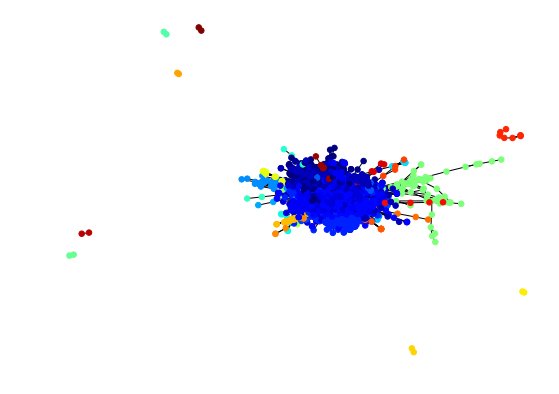

In [130]:
locoms, part,values = louvain(graphs_C[0].g)
graphs_C[0].locoms(locoms)

(array([ 3200.,  2044.,   107.,    30.,     7.,    84.,    23.,    38.,
           25.,    15.]),
 array([  0. ,   3.8,   7.6,  11.4,  15.2,  19. ,  22.8,  26.6,  30.4,
         34.2,  38. ]),
 <a list of 10 Patch objects>)

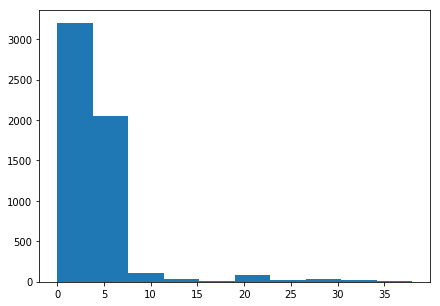

In [131]:
hist(values)

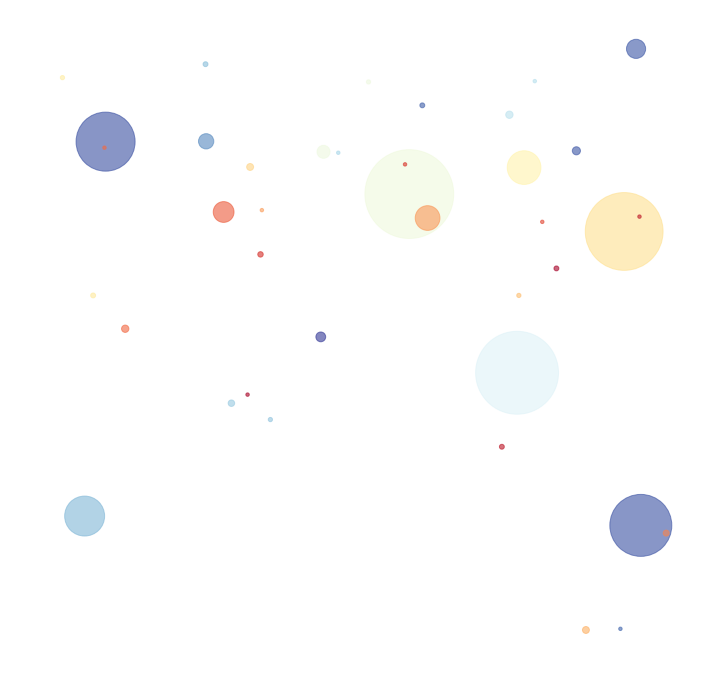

                       min          max         avg         std
Index                                                          
Internal Density  0.000927     0.250000    0.116107    0.092714
Edges inside      1.000000  3814.000000  345.282051  914.658377
Average Degree    1.000000     8.428571    2.444011    1.744482
FOMD              0.998477     1.000000    0.999961    0.000241
TPR               0.000000     1.000000    0.228020    0.309249
Expansion         0.000000    19.214286    2.451568    3.159042
Cut Ratio         0.000000     0.003283    0.000430    0.000543
Conductance       0.000000     0.800000    0.419189    0.227975
Normalized Cut    0.000000     0.800186    0.428812    0.227933
Maximum-ODF       0.000000   374.000000   44.615385   91.375140
Average-ODF       0.000000    19.214286    2.451568    3.159042
Flake-ODF         0.000000     1.000000    0.289116    0.361879
                            value
Index                            
Modularity (no overlap)  0.391163


In [132]:
bubblechart(part)

87 partitions


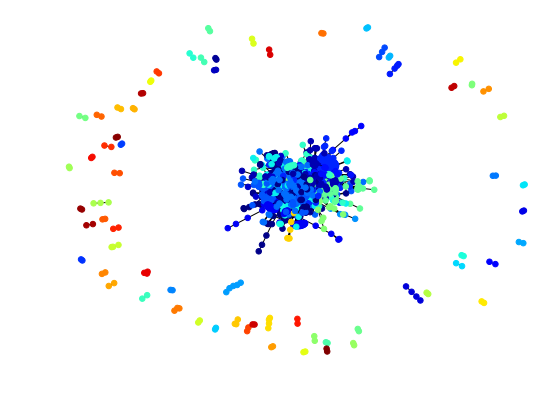

In [133]:
locoms, part,values = louvain(graphs_C[1].g)
graphs_C[1].locoms(locoms)

(array([ 535.,  378.,  327.,  108.,  145.,   34.,   25.,   17.,   18.,   19.]),
 array([  0. ,   8.6,  17.2,  25.8,  34.4,  43. ,  51.6,  60.2,  68.8,
         77.4,  86. ]),
 <a list of 10 Patch objects>)

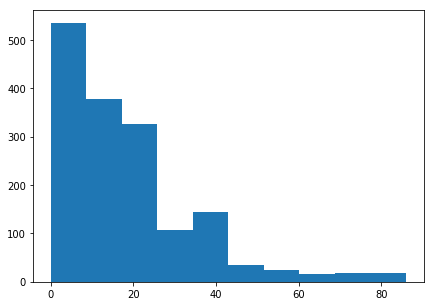

In [134]:
hist(values)

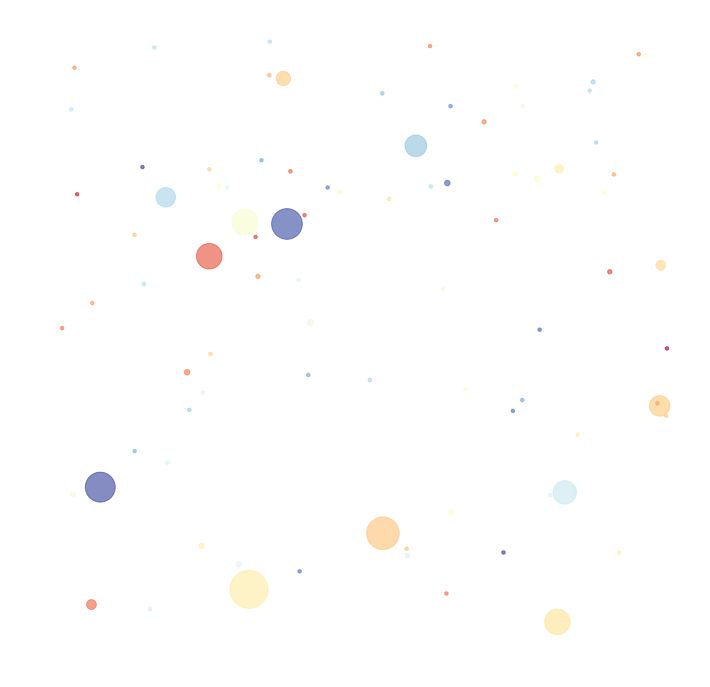

                       min         max        avg         std
Index                                                        
Internal Density  0.003434    0.250000   0.192206    0.089806
Edges inside      1.000000  769.000000  40.919540  124.559197
Average Degree    1.000000   14.110092   1.655372    1.709690
FOMD              0.970588    1.000000   0.999597    0.003186
TPR               0.000000    0.750000   0.095043    0.206156
Expansion         1.000000   37.833333  10.062427    8.471243
Cut Ratio         0.000170    0.006440   0.001719    0.001447
Conductance       0.496068    0.972603   0.812396    0.118420
Normalized Cut    0.500047    0.974252   0.818158    0.117455
Maximum-ODF       2.000000  777.000000  56.436782  113.836513
Average-ODF       1.000000   37.833333  10.062427    8.471243
Flake-ODF         0.233333    1.000000   0.676698    0.233062
                           value
Index                           
Modularity (no overlap)  0.03813


In [135]:
bubblechart(part)

Text(0.5,1,'Top 100 Degree')

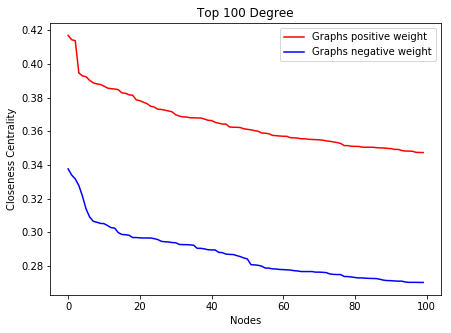

In [152]:
for obj in graphs_C:
    obj.closeCen(nbest_centrality(obj.g, nx.closeness_centrality))
fig = figure()
ax = fig.add_subplot(111)
ax.plot([  item[1] for idx, item in enumerate(graphs_C[0].degClose[0:100])],'r-') # dfp
ax.plot([  item[1] for idx, item in enumerate(graphs_C[1].degClose[0:100])],'b-') # dfn
plt.xlabel("Nodes")
plt.ylabel("Closeness Centrality")
plt.legend([graphs_C[0].name,graphs_C[1].name])
plt.title("Top 100 Degree")